# **CHAPTER 10 확산 모델 응용**

* 대표 서비스:

  * **Stable Diffusion**
  * **Midjourney**

* 공통 특징:

  * **텍스트 → 이미지 생성**
  * **조건부 확산 모델 (Conditional Diffusion Model)** 기반

* 이번 장 주요 내용:

  * 조건부 확산 모델의 **동작 원리** 이해
  * 실제 **구현 방법** 소개
  * Stable Diffusion 등 **첨단 생성 AI의 요소 기술** 설명

---


##  **10.1 조건부 확산 모델**

* **기존 확산 모델의 목적**

  * 데이터 자체의 확률 분포인 $p(\boldsymbol{x})$ 를 모델링함
  * 하지만 이 방식은 **제어 가능한 생성**에는 한계가 있음

* **조건부 확산 모델의 필요성**

  * $p(\boldsymbol{x} \mid y)$: 조건 $y$ 가 주어졌을 때의 $x$ 생성 확률
  * 조건 $y$ 를 설정함으로써 생성 결과를 **명시적으로 제어** 가능

* **조건 $y$ 의 예시**

  * 텍스트
  * 이미지 (예: 저해상도 → 고해상도 변환)
  * 레이블 (예: 숫자 클래스)

* **응용: 초해상도 (Super Resolution)**

  * 조건 $y$: 저해상도 이미지
  * 결과 $x$: 고해상도 이미지
  * 사용 모델: **계단식 확산 모델 (Cascaded Diffusion Model)** 등

* **실습 예제 (MNIST)**

  * 조건 $y$: 숫자 레이블 (예: ‘3’)
  * 모델은 해당 숫자에 **해당하는 손글씨 이미지 $x$** 를 생성
  * 텍스트 조건 대신 **클래스 정보로 제어**하는 조건부 생성 방식

<img src="./img/fig_10_01.png" width=800>

---

### 10.1.1 확산 모델에 조건 추가

* 확산 모델에서는 신경망을 이용해 다음 중 하나를 예측함:

  * 평균 이미지 예측:

    $$
    \boldsymbol{\mu}_{\theta}(\boldsymbol{x}_t, t)
    $$
  * 노이즈 성분 예측:

    $$
    \boldsymbol{\varepsilon}_{\theta}(\boldsymbol{x}_t, t)
    $$

<img src="./img/fig_10_02.png" width=800>

* 위쪽: $\boldsymbol{\mu}_{\theta}(\boldsymbol{x}_t, t)$ 를 출력하는 신경망 구조
* 아래쪽: $\boldsymbol{\varepsilon}_{\theta}(\boldsymbol{x}_t, t)$ 를 출력하는 구조

* 해당 신경망을 통해 **역확산 분포**를 모델링:

  $$
  p_{\theta}(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t) = \mathcal{N}\left(\boldsymbol{x}_{t-1}; \boldsymbol{\mu}_{\theta}(\boldsymbol{x}_t, t), \sigma_q^2(t) \mathbf{I}\right)
  $$

* 전체 생성 확률:

  $$
  p_{\theta}(\boldsymbol{x}_0) = \int p_{\theta}(\boldsymbol{x}_0 \mid \boldsymbol{x}_1) \cdots p_{\theta}(\boldsymbol{x}_{T-1} \mid \boldsymbol{x}_T) \, p(\boldsymbol{x}_T) \, d\boldsymbol{x}_1 \cdots d\boldsymbol{x}_T
  $$

  * 이때 초기 분포는 다음과 같이 설정:

    $$
    p(\boldsymbol{x}_T) = \mathcal{N}(\mathbf{0}, \mathbf{I})
    $$

**조건부 확산 모델로의 확장**

* 목표: **조건이 주어졌을 때의 데이터 분포 모델링**

  $$
  p_{\theta}(\boldsymbol{x}_0 \mid y)
  $$

* 방법: 각 시점의 조건부 확률에 $y$를 추가하여 다음과 같이 모델링

  $$
  p_{\theta}(\boldsymbol{x}_0 \mid y) = \int p_{\theta}(\boldsymbol{x}_0 \mid \boldsymbol{x}_1, y) \cdots p_{\theta}(\boldsymbol{x}_{T-1} \mid \boldsymbol{x}_T, y) \, p(\boldsymbol{x}_T) \, d\boldsymbol{x}_1 \cdots d\boldsymbol{x}_T
  $$

* 각 시점의 조건부 분포는 다음과 같이 정의됨:

  $$
  p_{\theta}(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, y) = \mathcal{N}\left(\boldsymbol{x}_{t-1}; \boldsymbol{\mu}_{\theta}(\boldsymbol{x}_t, t, y), \sigma_q^2(t) \mathbf{I}\right)
  $$

* 즉, 신경망의 입력에 조건 $y$ 를 추가하면 조건부 확산 모델이 됨:

  * 평균 예측 버전:

    $$
    \boldsymbol{\mu}_{\theta}(\boldsymbol{x}_t, t, y)
    $$
  * 노이즈 예측 버전:

    $$
    \boldsymbol{\varepsilon}_{\theta}(\boldsymbol{x}_t, t, y)
    $$

<img src="./img/fig_10_03.png" width=800>


* 조건 $y$를 함께 입력받는 신경망 구조
* 입력: $\boldsymbol{x}_t, t, y$ → 출력: 평균 또는 노이즈 예측

---

### 10.1.2 조건부 확산 모델 구현


* 기존 확산 모델:
  $\varepsilon_{\theta}(\boldsymbol{x}_t, t)$ — 시각 $t$만을 조건으로 사용
* 조건부 확산 모델:
  $\varepsilon_{\theta}(\boldsymbol{x}_t, t, y)$ — 조건 $y$(정수형 레이블)도 입력으로 사용

<img src="./img/fig_10_04.png" width=800>

  * $t$: **사인파 위치 인코딩** → 고정된 벡터
  * $y$: **임베딩 계층**(`nn.Embedding`) → 학습 가능한 벡터
  * 두 벡터를 **합산**하여 조건 임베딩 벡터로 사용


>**NOTE** 
>
>- **레이블 $y$**: 학습 가능한 **임베딩 계층**을 통해 벡터로 변환됨
>
>   → 초기값은 무작위이며, 학습을 통해 각 레이블에 특화된 표현 학습 가능
>
>- **시각 $t$**: 학습 대상이 아니므로
>
>   → **사인파 위치 인코딩**(고정된 함수 기반 변환)을 사용하여 벡터화함

**UNetCond 클래스**

* `UNetCond`는 조건부 확산 모델을 위한 **U-Net 기반 신경망**입니다. 기존 확산 모델과의 차이는 **시각 정보(t)** 뿐 아니라 **조건 레이블(y)** 도 함께 사용한다는 점입니다.
* 기존 UNet에 레이블 임베딩 기능 추가
* 주요 변경:

  * `self.label_emb = nn.Embedding(num_labels, time_embed_dim)`
  * forward에서 `t += self.label_emb(labels)` 처리 추가


```python
import torch
import torch.nn as nn
from pos_encoding import pos_encoding  # 사인파 위치 인코딩 함수
# ConvBlock은 기존 U-Net 구조에서 사용한 합성곱 블록 클래스

class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        """
        조건부 확산 모델용 U-Net 정의
        - in_ch: 입력 이미지 채널 수 (MNIST는 1)
        - time_embed_dim: 시각(t)과 레이블(y)의 임베딩 차원
        - num_labels: 레이블 클래스 수 (예: MNIST는 10)
        """
        super().__init__()
        self.time_embed_dim = time_embed_dim

        # U-Net 구조: 다운샘플링 → 중간 → 업샘플링
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1  = ConvBlock(128, 256, time_embed_dim)
        self.up2   = ConvBlock(128 + 256, 128, time_embed_dim)  # 스킵 연결 포함
        self.up1   = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out   = nn.Conv2d(64, in_ch, kernel_size=1)  # 최종 출력 계층

        self.maxpool  = nn.MaxPool2d(2)  # 다운샘플링
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')  # 업샘플링

        # (1) 레이블 y를 처리하기 위한 임베딩 계층
        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        """
        - x: 입력 이미지 텐서 (N, C, H, W)
        - timesteps: 시각 t (정수 텐서, shape: (N,))
        - labels: 조건 레이블 y (정수 텐서, shape: (N,))
        """
        # (2) 시각 정보를 사인파 위치 인코딩으로 변환
        t = pos_encoding(timesteps, self.time_embed_dim, x.device)

        # (3) 레이블이 주어진 경우, 임베딩 후 시각 인코딩 벡터에 더함
        if labels is not None:
            t += self.label_emb(labels)  # shape: (N, time_embed_dim)

        # (4) U-Net 순전파 과정 (스킵 연결 포함)
        x1 = self.down1(x, t)
        x = self.maxpool(x1)

        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)
        x = self.upsample(x)

        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)

        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)

        x = self.out(x)
        return x
```

**변경된 주요 내용 (2가지)**

1. **레이블을 위한 임베딩 계층 추가**

   * 코드:

     ```python
     self.label_emb = nn.Embedding(num_labels, time_embed_dim)
     ```
   * 설명:

     * `num_labels`개의 정수형 레이블을 각각 `time_embed_dim` 크기의 벡터로 변환
     * 학습 가능한 파라미터로, 학습 과정 중 최적화됨

2. **시각 벡터 $t$와 레이블 임베딩 $y$를 더해 조건 벡터 생성**

   * 코드:

     ```python
     t = pos_encoding(timesteps, self.time_embed_dim)
     t += self.label_emb(labels)
     ```
   * 설명:

     * 시각 정보는 **사인파 위치 인코딩(positional encoding)** 으로 고정된 벡터 생성
     * 레이블은 **학습 가능한 임베딩 벡터**로 변환
     * 두 벡터를 **더함**으로써 최종 조건 임베딩 벡터 완성


**모델 동작 요약**

| 요소                    | 처리 방식                 | 설명                      |
| --------------------- | --------------------- | ----------------------- |
| `t`                   | 사인파 위치 인코딩            | 정수 시각값을 고정된 벡터로 변환      |
| `labels`              | `nn.Embedding`        | 정수형 레이블을 학습 가능한 벡터로 변환  |
| `t + label_embedding` | 조건 임베딩 벡터 생성          | 시각 + 레이블 정보를 하나의 벡터로 통합 |
| `ConvBlock`           | 입력 `x`와 조건 임베딩 `t` 처리 | 다운/업샘플링 블록에서 조건 벡터 사용   |

**ConvBlock 사용 방식**

* 각 블록은 입력 이미지 특성맵 `x` 외에 조건 벡터 `t`도 함께 처리함
* 구조적으로 `x`에 조건 벡터를 더해 주입하는 방식 (예: 브로드캐스트 후 덧셈)


**Diffuser 클래스 수정**

* `denoise()` 및 `sample()` 메서드에서 `labels` 인수 추가
* 무작위 레이블 생성: `torch.randint(0, 10, (batch_size,), device=self.device)`
* 생성 루프에서 매 시점 `t`와 함께 `labels`를 모델에 전달

다음은 Diffuser 클래스입니다. Diffuser 클래스에서는 데이터를 생성하는 메서드를 변경합 니다. 변경된 부분만 표시하면 다음과 같습니다.

```python
class Diffuser:
    def denoise(self, model, x, t, labels):
        # ...(생략)
        with torch.no_grad():
            eps = model(x, t, labels) # labels도 제공
        # ...
    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        # ...
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)
        # ...
        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device,
                    dtype=torch.long)
            x = self.denoise(model, x, t, labels) # labels도 제공
        # ...
        return images, labels
```

**학습 루프 변경**

* UNetCond 인스턴스 생성 시 `num_labels=10` 지정
* 각 배치의 `labels`를 `.to(device)`로 처리
* 모델 호출 시 `model(x_noisy, t, labels)` 형태로 전달


```python
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)  # (1) 조건 레이블 y를 입력으로 받는 UNet
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    for images, labels in tqdm(dataloader):  # ⏳ 학습 진행률 시각화
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)  # (2) 조건 레이블도 입력으로 사용됨

        t = torch.randint(1, num_timesteps + 1, (x.size(0),), device=device)
        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)  # (3) 모델은 x_noisy, t, y로 노이즈 예측

        loss = F.mse_loss(noise, noise_pred)
        loss.backward()         # ✅ 루프 안으로 이동
        optimizer.step()        # ✅ 루프 안으로 이동

        loss_sum += loss.item()
        cnt += 1

    avg_loss = loss_sum / cnt
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    losses.append(avg_loss)

```

<img src="./img/fig_10_05.png" width=800>

* 조건부 확산 모델이 생성한 이미지
* 아래 숫자는 입력된 조건 레이블
* 이미지들이 조건에 대체로 부합함을 시각적으로 확인 가능

---

### conditional.py

100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Epoch 0 | Loss: 0.04568584370555908


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 1 | Loss: 0.026273404156713726


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 2 | Loss: 0.022852336632401576


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 3 | Loss: 0.020858494729709142


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 4 | Loss: 0.020055379541809245


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 5 | Loss: 0.018945462177636655


100%|██████████| 469/469 [00:31<00:00, 14.82it/s]


Epoch 6 | Loss: 0.01828426170919432


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 7 | Loss: 0.01948646841042522


100%|██████████| 469/469 [00:31<00:00, 14.82it/s]


Epoch 8 | Loss: 0.01806638815970436


100%|██████████| 469/469 [00:31<00:00, 14.83it/s]


Epoch 9 | Loss: 0.01747635205480844


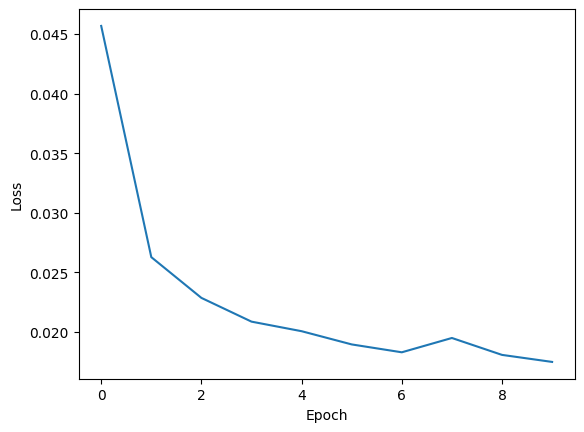

100%|██████████| 1000/1000 [00:05<00:00, 173.76it/s]


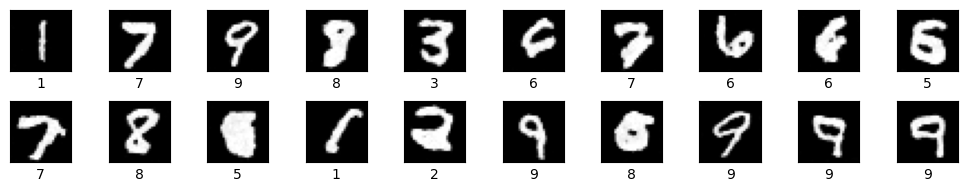

In [1]:
# 필요한 라이브러리 임포트
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


# 하이퍼파라미터 설정
img_size = 28  # MNIST 이미지 크기
batch_size = 128  # 배치 크기
num_timesteps = 1000  # 타임스텝 수
epochs = 10  # 학습 에폭 수
lr = 1e-3  # 학습률
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # GPU 사용 여부 확인


# 이미지 시각화 함수
def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

# 시간 임베딩을 위한 포지셔널 인코딩 함수
def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

# 컨볼루션 블록 클래스 정의
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        # 컨볼루션 레이어 시퀀스
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        # 시간 임베딩을 위한 MLP
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

# 조건부 U-Net 모델 클래스
class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        # U-Net 구조의 레이어들
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        # 레이블 임베딩 레이어 (조건부 생성을 위함)
        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        # 시간 임베딩 계산
        t = pos_encoding(timesteps, self.time_embed_dim)

        # 레이블이 있는 경우 레이블 임베딩 추가
        if labels is not None:
            t += self.label_emb(labels)

        # U-Net forward pass
        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x


# 확산 모델 클래스
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        # 노이즈 스케줄 설정
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    # 노이즈 추가 함수
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    # 노이즈 제거 함수
    def denoise(self, model, x, t, labels):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    # 이미지 변환 함수
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    # 샘플 생성 함수
    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels


# 데이터 전처리 및 데이터로더 설정
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='~/data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델 초기화
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

# 학습 루프
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # 매 에폭마다 샘플 생성 (주석 처리됨)
    # images, labels = diffuser.sample(model)
    # show_images(images, labels)

    # 배치 학습
    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    # 에폭당 평균 손실 계산 및 출력
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# 학습 손실 그래프 출력
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 최종 샘플 생성 및 출력
images, labels = diffuser.sample(model)
show_images(images, labels)

----

## **10.2 점수 함수**

* 앞 절의 조건부 확산 모델은 단순히 조건을 입력에 추가한 구조

  → 조건이 제대로 반영되지 않거나 무시될 수 있는 한계 존재

> - `label` 정보의 **gradient**가 약해져 **backpropagation**을 통해 학습되지 않음
> - `label`이 입력 이미지나 구조에 명확히 연결되지 않으면, 모델이 무시하기 쉬움
> - `denoise()`나 `sample()`에서 매 스텝마다 label을 사용하지만, 조건을 강제하지 않고 그냥 "참고용" 정보로만 쓸 뿐 → 무시될 수 있음  

* 이를 개선하기 위한 방법이 **가이던스(guidance)**

  → 조건을 **더 강하게 반영**하도록 유도하는 기법

* **가이던스를 이해하기 위한 전제**:

  → **점수 함수(score function)** 개념을 먼저 이해해야 함

* 이번 절 목표:

  → **점수 함수의 개념 설명**
  → 다음 절의 가이던스 기법 이해를 위한 기반 마련

---

### 10.2.1 점수 함수란?

* 기존 확산 모델에서는 다음과 같은 신경망을 사용함:

  $$
  \varepsilon_{\theta}(\boldsymbol{x}_t, t)
  $$

  → 입력 $\boldsymbol{x}_t$와 시각 $t$로부터 노이즈 $\varepsilon$ 를 예측

<img src="./img/fig_10_06.png" width=800>

**점수 함수와의 관계**

* 노이즈 $\varepsilon$ 는 다음과 같이 점수 함수로 근사 가능:

$$
\varepsilon \approx -\sqrt{1 - \bar{\alpha}_t} \cdot \nabla_{\boldsymbol{x}_t} \log p(\boldsymbol{x}_t)
$$  
<p align="center">[식 10-1]</p>  

* 여기서,

  * $\nabla_{\boldsymbol{x}_t} \log p(\boldsymbol{x}_t)$: 로그 가능도의 $\boldsymbol{x}_t$에 대한 **기울기**
  * 이를 **점수 함수(score function)** 또는 **점수(score)** 라고 함
  * $\nabla$ 는 기울기를 뜻하는 기호이며 '나블라'nable'라고 읽음

>**주의:**
>
>* $p(\boldsymbol{x}_t)$: 실제 확률 밀도 함수
>* $p_\theta(\boldsymbol{x}_t)$: 모델이 근사한 확률 밀도 함수
>
>   →  $\nabla_{x_{t}} \log p\left(x_{t}\right)$ 와 $\nabla_{x_{t}} \log p_{\theta}\left(x_{t}\right)$ 는 모두 입력 $x_{t}$ 에 대한 기 울기를 뜻하므로 **점수**라고 함


**점수 함수 기반 확산 모델 정리**

[식 10.1]에 따르면, 확산 모델에서 예측하는 노이즈 $\varepsilon$ 는 다음과 같이 **점수 함수(score function)** 와 관련됩니다:

$$
\varepsilon \approx -\sqrt{1 - \bar{\alpha}_t} \cdot \nabla_{\boldsymbol{x}_t} \log p(\boldsymbol{x}_t)
$$
<p align="center">[식 10-1]</p>  

* 즉, 노이즈 $\varepsilon$ 는 입력 $\boldsymbol{x}_t$에 대한 로그 가능도의 **기울기**에 **상수배를 취한 것**입니다.
* 이 기울기 $\nabla_{\boldsymbol{x}_t} \log p(\boldsymbol{x}_t)$ 를 **점수(score)** 또는 **점수 함수**라고 부릅니다.

>**왜 점수 함수 라고 불리는가?**
>
>* 점수 함수는 **로그 가능도 $\log p(x)$** 를 **입력 $x$** 에 대해 미분한 것
>
>  → 확률 밀도가 **가장 빠르게 증가하는 방향**을 나타냄
>
>* 이 방향은 **데이터가 더 그럴듯해지는 쪽**을 가리키므로, 일종의 **"확률적 점수"** 로 해석 가능
>
>* 통계학에서도 파라미터에 대한 기울기를 **"점수 함수"** 라 불러 왔으며, 같은 의미로 사용됨
>
>* 확산 모델에서는 이 점수 함수가 **노이즈 제거 방향**과 거의 일치함
>
>  → 따라서 이를 직접 학습하거나 활용할 수 있음

**점수 추정 기반 모델로의 전환**

* 위 식을 변형하면, 점수 함수는 다음과 같이 표현됩니다:

$$
\nabla_{\boldsymbol{x}_t} \log p(\boldsymbol{x}_t) \approx -\frac{1}{\sqrt{1 - \bar{\alpha}_t}} \varepsilon
$$

* 따라서 기존에 $\varepsilon$ 을 예측하던 신경망 대신,
  다음 값을 직접 추정하도록 학습할 수 있습니다:

$$
s_{\theta}(\boldsymbol{x}_t, t) \approx -\frac{1}{\sqrt{1 - \bar{\alpha}_t}} \varepsilon
$$

→ 이 구조를 **점수 추정 신경망(score network)** 이라고 부릅니다.

<img src="./img/fig_10_07.png" width=800>

* $s_\theta(\boldsymbol{x}_t, t)$ 가 점수를 직접 예측
* 즉, 정규화된 노이즈 값을 학습 대상으로 하는 신경망 구조

>**참고: 점수 기반 생성 모델**
>
>* **점수 기반 생성 모델(score-based generative models)**:
>  점수 함수 자체를 모델링하여 샘플을 생성
>* 반면, 기존 확산 모델, VAE, GMM 등은 **가능도 기반 생성 모델(likelihood-based models)**
>
>→ 확산 모델은 **점수 기반 방식으로도 구현 가능**하며, 이 방향에 대한 연구도 활발함

---


### 10.2.2 \[식 10.1]의 증명 ★

이번 점에서는 [식 10.1 ]이 성립함을 증명합니다.

$$\varepsilon \approx-\sqrt{1-\bar{\alpha}_{t}} \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)$$
<p align="center">[식 10-1]</p>  

복습부터 하겠습니다. 시각 $t$ 의 노이즈 데이터 $\boldsymbol{x}_{t}$ 는 원본 데이터인 $\boldsymbol{x}_{0}$ 으로부터 다음과 같은 정 규 분포를 통해 생성할 수 있습니다.

$$
q\left(\boldsymbol{x}_{t} \mid \boldsymbol{x}_{0}\right)=\mathcal{N}\left(\boldsymbol{x}_{t} ; \sqrt{\bar{\alpha}_{t}} \boldsymbol{x}_{0},\left(1-\bar{\alpha}_{t}\right) \mathbf{I}\right)
$$
<p align="center">[식 10-2]</p>  

제배개변수화 트럭을 사용하면 $\boldsymbol{x}_{t}$ 의 샘플은 다음 식을 통해 얻을 수 있습니다.

$$
\begin{aligned}
\varepsilon & \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
\boldsymbol{x}_{t} & =\sqrt{\bar{\alpha}_{t}} \boldsymbol{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \varepsilon
\end{aligned}
$$
<p align="center">[식 10-3]</p>  

다음은 트위디 공식입니다.


>**트위디 공식(Tweedie's Formula)**
>
>$x \sim \mathcal{N}(\boldsymbol{x} ; \boldsymbol{\mu}, \boldsymbol{\Sigma})$ 로부터 샘플 $x$ 를 얻으면 다음 식이 성립한다.
>
>$$\mathbb{E}[\boldsymbol{\mu} \mid \boldsymbol{x}]=\boldsymbol{x}+\boldsymbol{\Sigma} \nabla_{x} \log p(\boldsymbol{x})$$
>
>* $\boldsymbol{\mu}$ 를 확률 변수로 취급
>
>* 왼쪽의 $\mathbb{E}[\boldsymbol{\mu} \mid \boldsymbol{x}]$ 는 $\boldsymbol{x}$ 가 조건으로 주어졌을 때 $\boldsymbol{\mu}$ 의 기댓값
>
>* 오른쪽의 $\nabla_{x} \log p(\boldsymbol{x})$ 는 점수

이 공식을 [식 10.2 ]에 적용합니다.

>**트위디 공식 적용**
>
>다음과 같이 가우시안 분포로부터 샘플 $\boldsymbol{x}_t$ 를 얻었다고 하자:
>$$\boldsymbol{x}_{t} \sim \mathcal{N}\left(\boldsymbol{x}_{t} ; \sqrt{\bar{\alpha}_{t}} \boldsymbol{x}_{0}, \left(1 - \bar{\alpha}_{t}\right) \mathbf{I} \right)$$
>
>이때 다음 식이 성립한다:
>
>$$\begin{aligned}\mathbb{E}\left[\sqrt{\bar{\alpha}_{t}} \boldsymbol{x}_{0} \mid \boldsymbol{x}_{t}\right]&= \boldsymbol{x}_{t} + \left(1 - \bar{\alpha}_{t} \right) \mathbf{I} \nabla_{\boldsymbol{x}_{t}} \log p(\boldsymbol{x}_{t}) \\&= \boldsymbol{x}_{t} + \left(1 - \bar{\alpha}_{t} \right) \nabla_{\boldsymbol{x}_{t}} \log p(\boldsymbol{x}_{t})\end{aligned}$$
><p align="center">[식 10-4]</p>  

이어서 [식 10.3 ]으로부터 $\sqrt{\bar{\alpha}_{t}} \boldsymbol{x}_{0}=\boldsymbol{x}_{t}-\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\varepsilon}$ 이 성립한다는 사실을 이용하여 식을 다 음과 같이 전개합니다.

$$
\begin{aligned}
& \mathbb{E}\left[\sqrt{\bar{\alpha}_{t}} \boldsymbol{x}_{0} \mid \boldsymbol{x}_{t}\right]=\boldsymbol{x}_{t}+\left(1-\bar{\alpha}_{t}\right) \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right) \\
\Leftrightarrow & \mathbb{E}\left[x_{t}-\sqrt{1-\bar{\alpha}_{t}} \varepsilon \mid \boldsymbol{x}_{t}\right]=\boldsymbol{x}_{t}+\left(1-\bar{\alpha}_{t}\right) \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right) \\
\Leftrightarrow & \mathbb{E}\left[\boldsymbol{x}_{t} \mid \boldsymbol{x}_{t}\right]-\mathbb{E}\left[\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\varepsilon} \mid \boldsymbol{x}_{t}\right]=\boldsymbol{x}_{t}+\left(1-\bar{\alpha}_{t}\right) \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right) \\
\Leftrightarrow & \boldsymbol{x}_{t}-\sqrt{1-\bar{\alpha}_{t}} \mathbb{E}\left[\boldsymbol{\varepsilon} \mid \boldsymbol{x}_{t}\right]=\boldsymbol{x}_{t}+\left(1-\bar{\alpha}_{t}\right) \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right) \\
\therefore & \mathbb{E}\left[\boldsymbol{\varepsilon} \mid \boldsymbol{x}_{t}\right]=-\sqrt{1-\bar{\alpha}_{t}} \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)
\end{aligned}
$$

기댓값 $\mathbb{E}\left[\boldsymbol{\varepsilon} \mid \boldsymbol{x}_{t}\right]$ 는 몬테카를로 방법으로 근사할 수 있습니다. 여기서는 $\boldsymbol{x}_{t}$ 를 하나의 샘플 데 이터로 근사하기로 합시다. 그러면 다음 식을 얻을 수 있습니다.
> "정확한 평균 대신 하나의 샘플만 보고 그걸 평균처럼 간주하자"는 일종의 근사 계산 전략

$$\varepsilon \approx-\sqrt{1-\bar{\alpha}_{t}} \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)$$
<p align="center">[식 10-1]</p>  

이상으로 [식 10.1 ]을 도출해냈습니다.

**수식 변형 과정 추가 설명**

$$
\mathbb{E}\left[x_t - \sqrt{1 - \bar{\alpha}_t} \varepsilon \mid x_t\right]
= \mathbb{E}[x_t \mid x_t] - \mathbb{E}[\sqrt{1 - \bar{\alpha}_t} \varepsilon \mid x_t]
$$

$$
= x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \mathbb{E}[\varepsilon \mid x_t]
$$

* **기댓값의 선형성**:
  $\mathbb{E}[A + B] = \mathbb{E}[A] + \mathbb{E}[B]$

* **상수 인수 분리**:
  $\mathbb{E}[c \cdot Z] = c \cdot \mathbb{E}[Z]$

* **항등식**:
  $\mathbb{E}[x_t \mid x_t] = x_t$

>**트위디 공식(Tweedie's Formula)은**
>* 트위디 공식은 **Maurice Tweedie**가 이름을 붙인 것으로, **Efron (1981)** 등이 통계적 추정에서 널리 소개했습니다.
>* 관측값이 노이즈가 섞인 정규분포에서 나왔다고 가정할 때, **숨겨진 평균값의 기대값(사후 평균)** 을 추정하는 방법입니다.
>* 이 추정은 관측값에 **사전 분포의 기울기(점수 함수)** 를 더해 보정하는 방식입니다.
>* 의미상, **노이즈를 제거하면서도 사전 지식에 기반한 정교한 추정을 가능하게** 합니다.
>* 확산 모델의 **역방향 과정 이론**과도 연결되어, 생성 모델에서도 핵심 개념으로 사용됩니다.  

---

## **10.3 분류기 가이던스**

* 앞 절에서 확산 모델을 **점수 함수 기반**으로 해석할 수 있음을 배움
* 이를 바탕으로 **가이던스(guidance)** 기법이 도입됨
* 가이던스는 모델이 조건(예: 레이블)을 **더 강하게 반영**하도록 유도하는 방법
* 크게 두 종류:

  * **분류기 가이던스** (classifier guidance)
  * **분류기 없는 가이던스** (classifier-free guidance)
* 이번 절에서는 먼저 **분류기 가이던스**부터 다룸

---

### 10.3.1 분류기란?

* **분류기 가이던스**는 분류기를 이용해 **데이터 생성을 유도하는 방법**이다.
* 여기서 **분류기**란, 노이즈가 섞인 이미지 $x_t$ 를 입력으로 받아 특정 클래스 $y$ 에 속할 확률 $p_{\phi}\left(y \mid \boldsymbol{x}_{t}\right)$를 출력하는 **학습된 신경망**을 의미한다.
  
  <img src="./img/fig_10_08.png" width=800>


**핵심 개념**

1. **기본 확산 모델**은 다음을 예측한다:
   $\nabla_{x_t} \log p(x_t)$
   *(데이터의 비조건부 점수 함수)*

2. **조건부 확산 모델**은 다음을 예측한다:
   $\nabla_{x_t} \log p(x_t \mid y)$
   *(특정 클래스 조건 하의 점수 함수)*

→ 이 두 식의 관계를 활용해 **분류기 가이던스** 방식이 도출된다. (즉, 기존 확산 모델에 **클래스 조건을 부여**하는 방식으로 확장 가능)

---


### 10.3.2 분류기 가이던스 도출

**1. 조건부 점수의 유도**

먼저 조건부 확률 $p\left(\boldsymbol{x}_{t} \mid y\right)$ 를 베이즈 정리를 이용해 다음 식으로 표현합니다.

$$
p\left(\boldsymbol{x}_{t} \mid y\right)=\frac{p\left(\boldsymbol{x}_{t}\right) p\left(y \mid \boldsymbol{x}_{t}\right)}{p(y)}
$$

그런 다음 $\boldsymbol{x}_{t}$ 에 대한 기울기 $\nabla_{\boldsymbol{x}_{t}}$ 를 구합니다.

$$
\begin{aligned}
\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right) & =\nabla_{\boldsymbol{x}_{t}} \log \left(\frac{p\left(\boldsymbol{x}_{t}\right) p\left(y \mid \boldsymbol{x}_{t}\right)}{p(y)}\right) \\
& =\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\nabla_{\boldsymbol{x}_{t}} \log p\left(y \mid \boldsymbol{x}_{t}\right)-\underbrace{\nabla_{\boldsymbol{x}_{t}} \log p(y)}_{0} \\
& =\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\nabla_{\boldsymbol{x}_{t}} \log p\left(y \mid \boldsymbol{x}_{t}\right)
\end{aligned}
$$

식 중간에 $\nabla_{x_{t}} \log p(y)$ 가 등장하는데 지금의 $p(y)$ 에는 $\boldsymbol{x}_{t}$ 가 포함되지 않으므로 $\nabla_{x_{t}} \log p(y)=$ 0 입니다. 이로부터 얻은 공식은 다음과 같습니다.

$$
\underbrace{\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right)}_{ \text {조건부 점수 }}=\underbrace{\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)}_{ \text {1. 점수 }}+\underbrace{\nabla_{\boldsymbol{x}_{t}} \log p\left(y \mid \boldsymbol{x}_{t}\right)}_{ \text {2. 분류기 로그 가능도의 기울기 }}
$$

**2. 각 항의 의미와 계산 방법**

- 1은 점수를 예측하는 신경망 $s_{i j}\left(x_{i}, t\right)$ 를 통해 계산할 수 있다.
- 2는 분류기 신경망으로 계산할 수 있다.

이처럼 '점수'와 '분류기'라는 두 신경망을 사용하여 조건부 점수를 표현할 수 있습니다(그리고 조건부 점수가 있으면 조건부 확산 모델을 구현할 수 있습니다). 또한 2의 $\nabla_{x_{t}} \log p\left(y \mid x_{t}\right)$ 는 역전파로 쉽게 구할 수 있습니다(그림 10-9).

<img src="./img/fig_10_09.png" width=800>

[그림 10-9]의 $\nabla_{x_{t}} \log p\left(y \mid x_{t}\right)$ 는 현재 $\boldsymbol{x}_{t}$ 에서 클래스 $y$ 의 로그 확률을 가장 크게 높이는 방향 을 나타냅니다. 따라서 $\boldsymbol{x}_{t}$ 를 $\nabla_{x_{t}} \log p\left(y \mid \boldsymbol{x}_{t}\right)$ 방향으로 갱신하면 갱신 후의 이미지는 클래스 $y$ 로 분류될 확률이 더욱 높아집니다.

분류기 가이던스라는 아이디어의 기본은 점수와 분류기를 이용해 조건부 점수를 표현하는 것 입니다. 

**3. 가중치 조절을 통한 가이던스 조정**

분류기의 영향력을 조정하기 위해 **스케일 파라미터** $\gamma$를 도입합니다:

$$\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right)=\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\gamma \nabla_{\boldsymbol{x}_{t}} \log p\left(y \mid \boldsymbol{x}_{t}\right)$$
<p align="center">[식 10-5]</p>  

- $\gamma$는 사람이 설정하는 값 (하이퍼파라미터)
- 분류기에 따라 클래스 $y$ 방향으로 안 내하는 정도를 조정
-  $\gamma$ 가 클수록 조건 $y$ 를 더 강하게 반영

점수를 추정하는 신경망 $\boldsymbol{s}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t}, t\right)$ 와 분류기 $p_{\phi}\left(y \mid \boldsymbol{x}_{t}\right)$ 를 사용하여 [식 10.5] 를 다시 써보겠습니다.

$$\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right) \approx \boldsymbol{s}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t}, t\right)+\gamma \nabla_{\boldsymbol{x}_{t}} \log p_{\boldsymbol{\phi}}\left(y \mid \boldsymbol{x}_{t}\right)$$
<p align="center">[식 10-6]</p>  

참고로 [식 10.6]에서 수행하는 처리를 그림으로 표현하면 [그림 10-10]과 같습니다.

<img src="./img/fig_10_10.png" width=800>

→ 기존 확산 모델에 분류기를 **결합**하여, 특정 클래스 조건을 반영한 **조건부 샘플 생성** 가능

* 점수 네트워크는 **노이즈 제거 방향** 제시
* 분류기 기울기는 **클래스 조건 강화 방향** 제공
* 이 둘을 합쳐 **클래스 조건이 반영된 생성 흐름**을 만들 수 있음

---



## **10.4 분류기 없는 가이던스**

* **분류기 가이던스**는 클래스 조건을 반영해 이미지를 생성할 수 있지만,
  
  → **별도의 분류기 신경망**을 **추가로 학습**해야 하므로 **실용성이 떨어지는 단점**이 있음

* 이를 개선한 것이 바로 **분류기 없는 가이던스 (Classifier-Free Guidance)**
  
  → **분류기를 사용하지 않고도** 조건부 생성이 가능함

---

### 10.4.1 분류기 없는 가이던스 개념

* 이름 그대로 **분류기를 따로 사용하지 않는 가이던스 방식**
* 기존 분류기 가이던스의 단점(분류기 신경망 필요)을 해결


기존 \[식 10-5]에 기반하여 베이즈 정리로 전개:

$$
\begin{aligned}
& \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right) \\
= & \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\gamma \nabla_{\boldsymbol{x}_{t}} \log p\left(y \mid \boldsymbol{x}_{t}\right) \\
= & \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\gamma \nabla_{\boldsymbol{x}_{t}} \log \frac{p\left(\boldsymbol{x}_{t} \mid y\right) p(y)}{p\left(\boldsymbol{x}_{t}\right)} \\
= & \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\gamma\left(\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right)+\underbrace{\nabla_{\boldsymbol{x}_{t}} \log p(y)}_{0}-\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)\right) \\
= & \nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)+\gamma\left(\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t} \mid y\right)-\nabla_{\boldsymbol{x}_{t}} \log p\left(\boldsymbol{x}_{t}\right)\right)
\end{aligned}
$$
<p align="center">[식 10-7]</p>  

→ **비조건부 점수 $\nabla_{x_{t}} \log p\left(x_{t}\right)$ 에서** 시작해 **조건부 점수 방향  $\nabla_{x_{t}} \log p\left(x_{t} \mid y\right)$ 으로** $\gamma$ 만큼 이동 하는 것을 의미

<img src="./img/fig_10_11.png" width=800>

각각은 다음 두 신경망으로 추정할 수 있습니다.

- 조건 없는 점수 추정: $s_{\theta_{1}}\left(x_{t}, t\right)$
- 조건부 점수 추정: $s_{\theta_{2}}\left(x_{t}, t, y\right)$

하지만 모델을 두 가지나 준비하려면 번거롭습니다. 그래서 $s_{\theta}\left(x_{t}, t, y\right)$ 라는 조건부 점수 추정 신경망 하나만 이용하여 다음과 같이 모델링합니다.

- 조건 없는 점수 추정: $s_{\theta}\left(x_{t}, t, \varnothing\right)$
- 조건부 점수 추정: $s_{\theta}\left(x_{t}, t, y\right)$

>'$\varnothing$ 는 ‘조건 없음’을 나타내는 **특수 클래스**로,
> 임베딩 계층을 통과할 때 **0 벡터**로 변환되어 **정보를 전달하지 않음**

**최종 공식: 분류기 없는 가이던스**

$$\nabla_{x_{t}} \log p\left(x_{t} \mid y\right) \approx s_{\theta}\left(x_{t}, t, \varnothing\right)+\gamma\left(s_{\theta}\left(x_{t}, t, y\right)-s_{\theta}\left(x_{t}, t, \varnothing\right)\right)$$
<p align="center">[식 10-8]</p>  

* 조건 없는 예측 결과에, 조건 정보가 반영된 보정값을 **가중치 $\gamma$만큼 더함**

<img src="./img/fig_10_12.png" width=800>

지금까지 점수 함수를 추정하는 신경망에 대해 설명했습니다. 그런데 점수와 노이즈는 상수 배 만큼 차이가 나기 때문에 노이즈를 추정하는 신경망의 구조도 이와 똑같습니다.

* 점수 함수와 노이즈 함수는 **상수 배 차이**
* 따라서 노이즈 예측 신경망도 **같은 방식으로 설계 가능**

>**NOTE.**
>
> 텍스트 → 이미지 생성에서는 **“생성되지 않기를 원하는 요소”** 를 네거티브 프롬프트(negative prompt)로 지정함



>**점수 함수와 노이즈 예측의 관계식**
>
> $$\boldsymbol{s}_\theta(\boldsymbol{x}_t, t) = - \frac{1}{\sigma_t^2} \cdot \hat{\boldsymbol{\varepsilon}}_\theta(\boldsymbol{x}_t, t)$$
>
> * $\boldsymbol{s}_\theta(\boldsymbol{x}_t, t)$ : 노이즈 예측 신경망의 출력
> * $\sigma_t$ : 시점 $t$에서의 노이즈 표준편차
> * $\hat{\boldsymbol{\varepsilon}}_\theta(\boldsymbol{x}_t, t)$ : 점수 함수 (로그 확률 기울기)

---

### 10.4.2 분류기 없는 가이던스 구현

- 조건부와 조건 없는 경우 모두 지원하도록 `forward()` 메서드를 수정:

```python
class UNetCond(nn.Module):
    # ... (기존 코드 생략)
    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)
        if labels is not None:
            # 조건이 주어졌을 경우에만 레이블 임베딩을 더함
            t += self.label_emb(labels)
        # 이후 계산 진행
        # ...
```

> `labels=None`이면 아무 일도 하지 않아 조건 없음(unconditional) 으로 처리됨

- 학습 중 **일정 비율(예: 10%)** 은 조건 없이 학습하도록 구현:

```python
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        # 10% 확률로 조건 없이 학습 (labels=None)
        if np.random.random() < 0.1:
            labels = None

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
```

- 이렇게 하면 모델이 **조건 있는/없는 경우 모두에 대응** 할 수 있게 학습됨

`Diffuser` 클래스 내 `denoise()` 함수 수정:

```python
class Diffuser:
    def denoise(self, model, x, t, labels, gamma):
        with torch.no_grad():
            # 조건부 노이즈 예측
            eps_cond = model(x, t, labels)
            # 조건 없는 노이즈 예측 (labels=None)
            eps_uncond = model(x, t)
            # 가이던스 적용
            eps = eps_uncond + gamma * (eps_cond - eps_uncond)
        return eps
```

- 인수 gamma의 값이 클수록 조건$\gamma$ 을 더 강하게 반영

$$\varepsilon \approx \varepsilon_{\theta}\left(\boldsymbol{x}_{t}, t, \varnothing\right)+\gamma\left(\varepsilon_{\theta}\left(\boldsymbol{x}_{t}, t, y\right)-\varepsilon_{\theta}\left(\boldsymbol{x}_{t}, t, \varnothing\right)\right)$$

* gamma = 3.0 으로 설정하여 학습한 후 생성된 이미지 → \[그림 10-13]
* 레이블에 따라 **정확한 숫자 이미지** 생성 성공

<img src="./img/fig_10_13.png" width=800>

---

### classifier_free_guidance.py

100%|██████████| 469/469 [00:31<00:00, 14.72it/s]


Epoch 0 | Loss: 0.04972497260233741


100%|██████████| 469/469 [00:31<00:00, 14.73it/s]


Epoch 1 | Loss: 0.027477650194248155


100%|██████████| 469/469 [00:31<00:00, 14.70it/s]


Epoch 2 | Loss: 0.023826760599322157


100%|██████████| 469/469 [00:31<00:00, 14.71it/s]


Epoch 3 | Loss: 0.02196219289647554


100%|██████████| 469/469 [00:31<00:00, 14.72it/s]


Epoch 4 | Loss: 0.020570511606011564


100%|██████████| 469/469 [00:31<00:00, 14.71it/s]


Epoch 5 | Loss: 0.019507442261459732


100%|██████████| 469/469 [00:31<00:00, 14.72it/s]


Epoch 6 | Loss: 0.019144822601109807


100%|██████████| 469/469 [00:31<00:00, 14.72it/s]


Epoch 7 | Loss: 0.018510743197220476


100%|██████████| 469/469 [00:31<00:00, 14.73it/s]


Epoch 8 | Loss: 0.017702808669174532


100%|██████████| 469/469 [00:31<00:00, 14.73it/s]


Epoch 9 | Loss: 0.0173505368525349


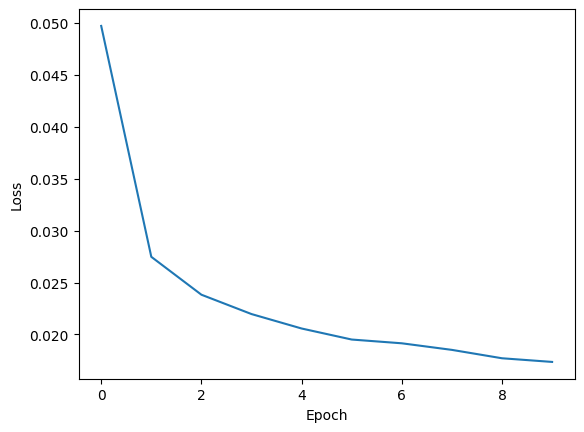

100%|██████████| 1000/1000 [00:10<00:00, 92.05it/s]


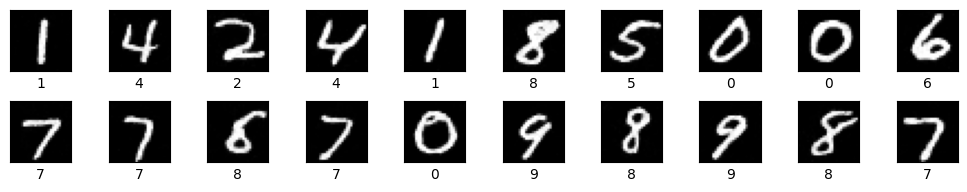

In [3]:
# 필요한 라이브러리 임포트
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


# 하이퍼파라미터 설정
img_size = 28  # 이미지 크기
batch_size = 128  # 배치 크기
num_timesteps = 1000  # 타임스텝 수
epochs = 10  # 학습 에폭 수
lr = 1e-3  # 학습률
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # GPU 사용 가능시 GPU 사용


# 이미지 시각화 함수
def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

# 시간 임베딩을 위한 포지셔널 인코딩 함수
def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

# 배치 단위 포지셔널 인코딩 함수
def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

# 컨볼루션 블록 클래스 정의
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

# 조건부 U-Net 모델 클래스 정의
class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        # U-Net 구조 정의
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        # 레이블 임베딩 레이어
        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)

        if labels is not None:
            t += self.label_emb(labels)

        # U-Net의 인코더-디코더 구조
        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x


# 확산 모델 클래스 정의
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        # 베타 스케줄 설정
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    # 노이즈 추가 함수
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    # 노이즈 제거 함수
    def denoise(self, model, x, t, labels, gamma):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        # 조건부/무조건부 노이즈 예측 및 가이던스 적용
        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
            eps_uncond = model(x, t)
            eps = eps_uncond + gamma * (eps - eps_uncond)
        model.train()

        # 노이즈 샘플링 및 평균/표준편차 계산
        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    # 이미지 변환 함수
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    # 이미지 생성 함수
    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels, gamma)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels


# 데이터 전처리 및 데이터로더 설정
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='~/data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델 초기화
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

# 학습 루프
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # 매 에폭마다 샘플 생성 (주석 처리됨)
    #images, labels = diffuser.sample(model)
    #show_images(images, labels)

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        # 10% 확률로 조건 없이 학습
        if np.random.random() < 0.1:
            labels = None

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    # 에폭당 평균 손실 계산 및 출력
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# 손실 그래프 출력
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 최종 샘플 생성 및 출력
images, labels = diffuser.sample(model)
show_images(images, labels)

## **10.5 스테이블 디퓨전**

지금까지는 **MNIST 수준의 소형 확산 모델**을 구현하며 원리를 익혀왔습니다.
하지만 실제로 사용되는 최신 확산 모델은 훨씬 **규모가 크고 복잡하며 고도화된 구조**를 갖습니다.

**Stable Diffusion 소개**

* 대표적인 **고해상도 이미지 생성 확산 모델**
* 누구나 사용할 수 있도록 **모델 가중치 및 코드가 공개**됨
* \[그림 10-14]와 같은 **고품질 이미지**를 생성할 수 있음

<img src="./img/fig_10_14.png" width=800>

>**Note**
>
> 스테이블 디퓨전은 서비스 이름으로도 많이 쓰이며 계속 발전 중입니다.
>
> 여기서 다루는 것은 논문 *High-Resolution Image Synthesis with Latent Diffusion Models*에 등장한 **원조 Stable Diffusion 모델**입니다.

---

### 10.5.1 스테이블 디퓨전의 구조

스테이블 디퓨전의 학습 흐름은 [그림 10-15]와 같습니다.

<img src="./img/fig_10_15.png" width=800>

그림과 같이 이미지와 텍스트를 주어 확산 모델을 학습시키면 U-Net의 매개변수가 갱신됩니다. 스테이블 디퓨전은 다음과 같은 세 가지 특징을 가지고 있습니다.

- **잠재 공간**: 잠재 공간에서 확산 모델을 처리한다.
- **CLIP**: 텍스트 인코딩용으로 CLIP  이라는 신경망을 사용한다.
- **Attention**: 이탠션 계층을 사용하여 U-Net에 조건을 도입한다.

**잠재 공간**

* 기존 확산 모델은 **픽셀 공간**(이미지 해상도 그대로)에서 노이즈를 처리함
* **스테이블 디퓨전은 인코더를 통해 잠재 공간으로 압축**하여 계산량을 줄임

<img src="./img/fig_10_16.png" width=800>

* 입력 이미지 → VAE 인코더 → **잠재 공간 $\boldsymbol{z}$**
* $\boldsymbol{z}_t$에 대해 노이즈 추가 및 역확산 수행
* 마지막에 VAE 디코더를 통해 다시 **이미지 복원**


**CLIP**

* 텍스트 → 벡터로 변환하기 위해 **CLIP(Contrastive Language Image Pre-training) 텍스트 인코더** 사용
* CLIP은 이미지와 텍스트의 **쌍 데이터**를 통해 학습되며, 이미지/텍스트를 **공통의 임베딩 공간**으로 매핑

<img src="./img/fig_10_17.png" width=800>

* 텍스트 인코더: 텍스트 → 벡터
* 이미지 인코더: 이미지 → 벡터
* 두 벡터의 **코사인 유사도**를 학습 대상으로 설정
* 유사도 높은 쌍은 가깝게, 부정적 쌍은 멀어지도록 학습

**어텐션**

* CLIP으로 얻은 **텍스트 임베딩**을 확산 모델에 조건으로 삽입
* 기존 조건부 모델은 단순 벡터 덧셈 방식이었다면, 스테이블 디퓨전은 **Cross-Attention**을 통해 정교하게 조건을 반영

<img src="./img/fig_10_18.png" width=800>

* **CLIP 텍스트 인코더**는 텍스트 프롬프트를 벡터로 변환합니다.
* 이 텍스트 임베딩은 **U-Net의 각 단계의 Attention 블록에 전달**됩니다.
* 각 **Attention 계층**은 U-Net의 **중간 feature map**과 텍스트 임베딩 간의 **유사도**를 계산 → 텍스트에 "주의(attend)"를 기울인 정보를 U-Net 내부 표현에 반영합니다.
* 사용된 어텐션은 **Cross-Attention**으로, 서로 다른 입력(이미지 vs 텍스트)을 연결합니다.
> 즉, Stable Diffusion은 **텍스트 조건을 이미지 생성 과정에 효과적으로 통합**하기 위해 **U-Net 내부 여러 위치에 Cross-Attention을 삽입**한 구조를 사용합니다.


---

### 10.5.2 Diffusers 라이브러리

* **Stable Diffusion**은 학습된 모델과 코드가 공개되어 있어 **누구나 무료로 사용할 수 있음**
* 그중에서도 **Hugging Face에서 제공하는 `Diffusers` 라이브러리**를 사용하면 **단 몇 줄의 코드로 이미지 생성**을 손쉽게 실행 가능

<img src="./img/fig_10_19.png" width=800>

**특징 및 장점**

* 사용이 간단하고 직관적
* 다양한 사전 학습된 확산 모델을 지원
* **이미지뿐 아니라 음성, 동영상, 3D 구조 생성 등** 여러 작업에 활용 가능
* **최신 논문 기반 기술을 빠르게 반영**하여 업데이트됨

>*자세한 사용법은 Hugging Face 공식 문서를 참고*
>
> [https://huggingface.co/docs/diffusers](https://huggingface.co/docs/diffusers)

---

### sd_test.py

In [ ]:
# !pip install --upgrade diffusers transformers accelerate scipy safetensors

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image 1/10...


  0%|          | 0/50 [00:00<?, ?it/s]

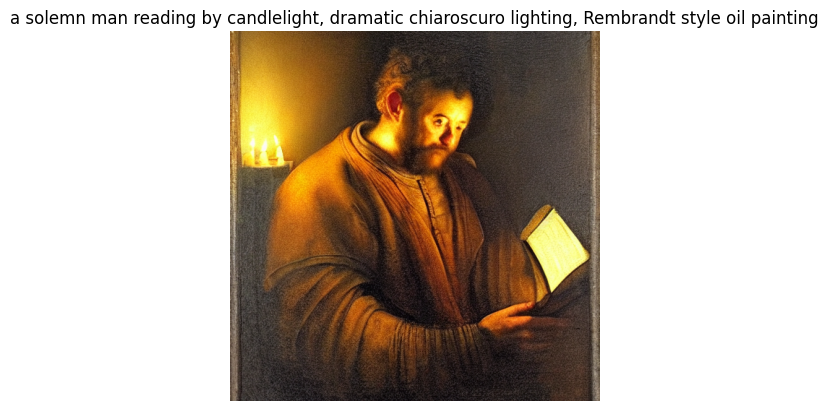

Generating image 2/10...


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


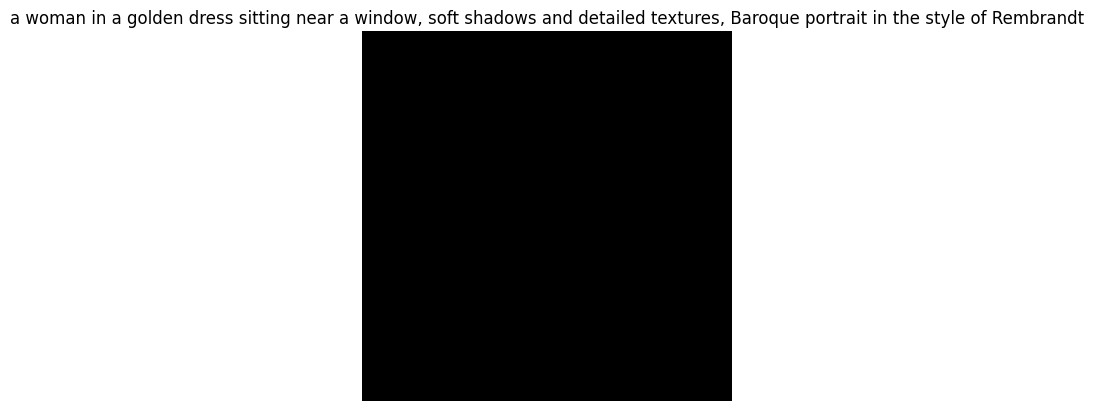

Generating image 3/10...


  0%|          | 0/50 [00:00<?, ?it/s]

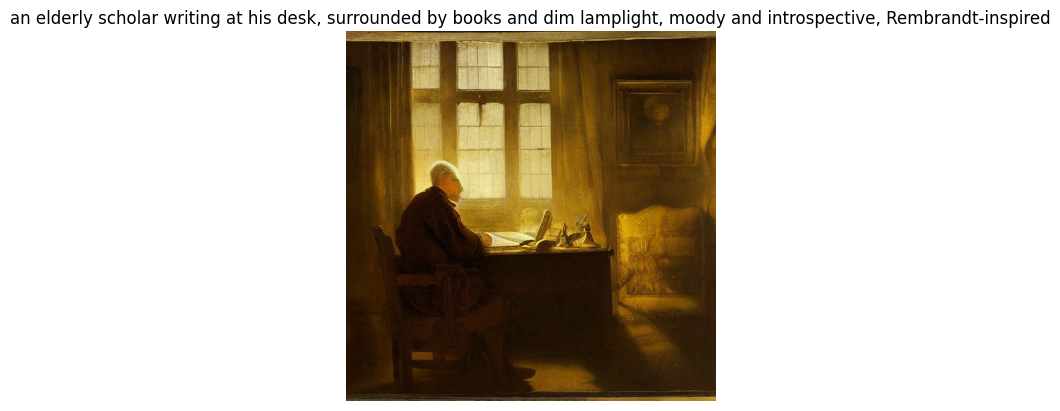

Generating image 4/10...


  0%|          | 0/50 [00:00<?, ?it/s]

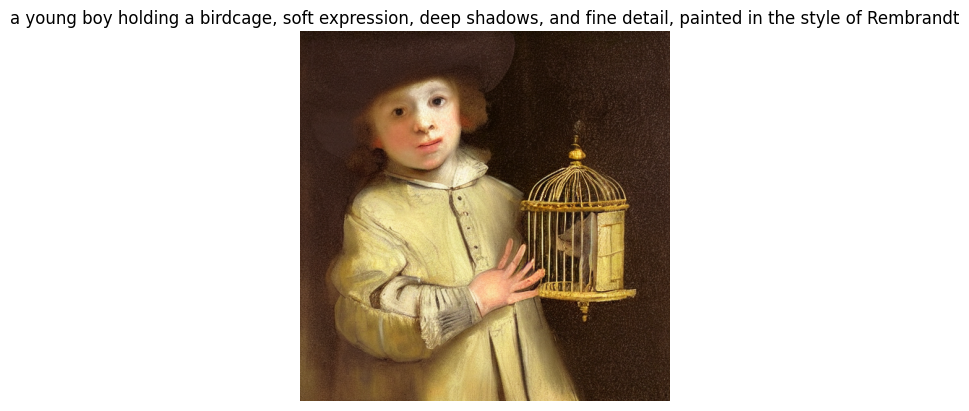

Generating image 5/10...


  0%|          | 0/50 [00:00<?, ?it/s]

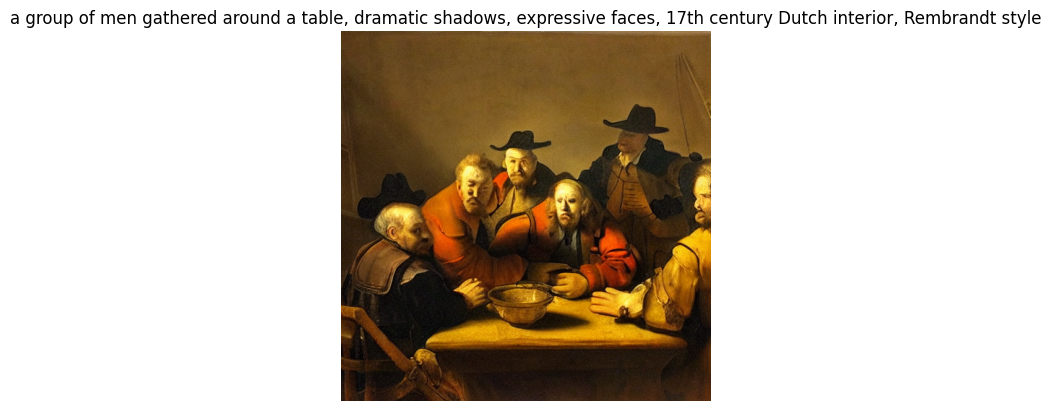

Generating image 6/10...


  0%|          | 0/50 [00:00<?, ?it/s]

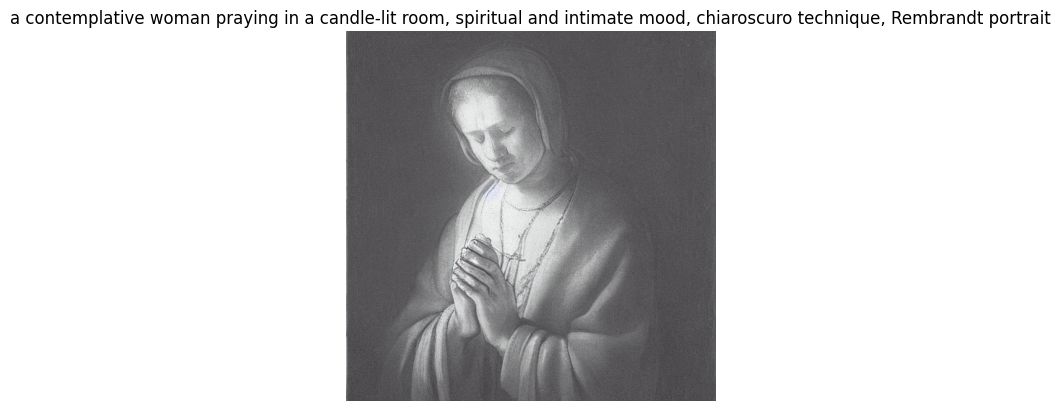

Generating image 7/10...


  0%|          | 0/50 [00:00<?, ?it/s]

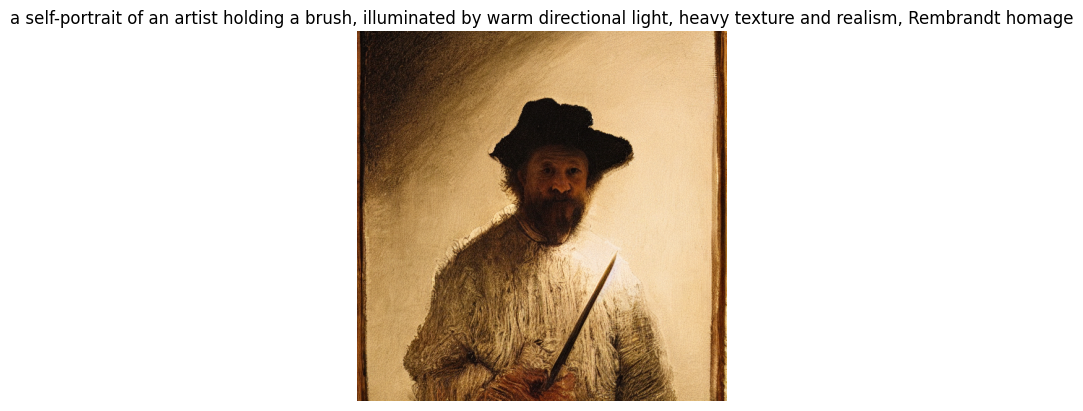

Generating image 8/10...


  0%|          | 0/50 [00:00<?, ?it/s]

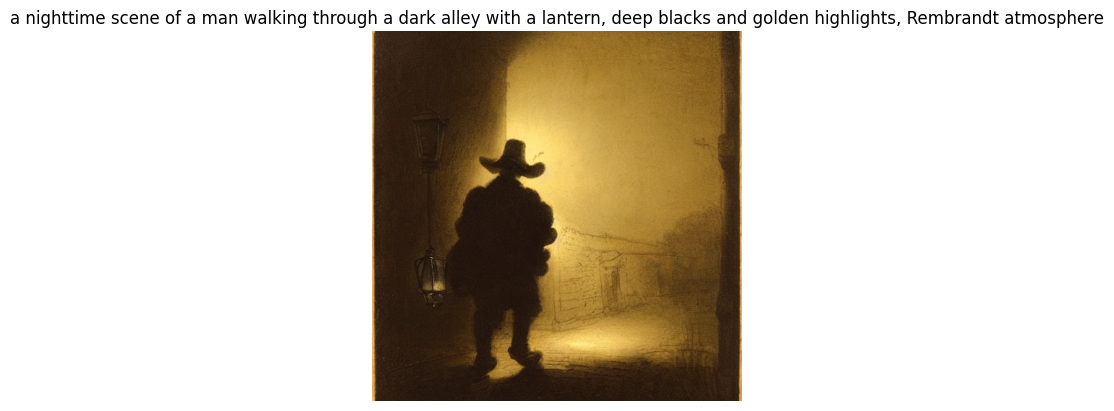

Generating image 9/10...


  0%|          | 0/50 [00:00<?, ?it/s]

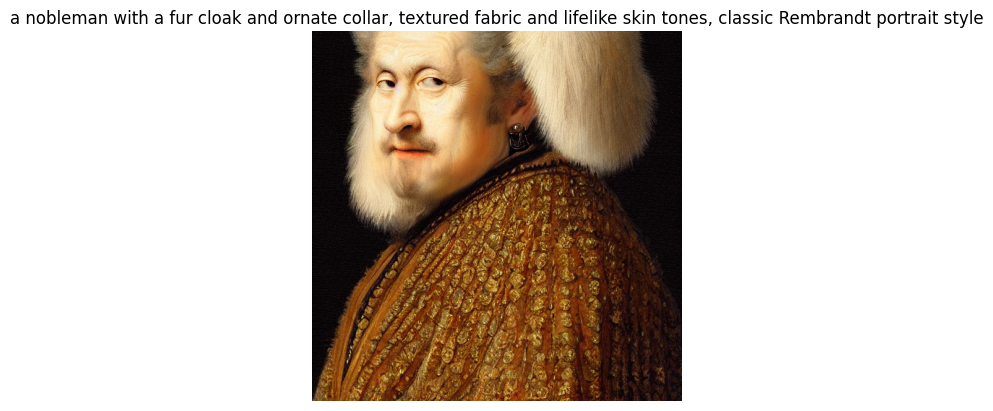

Generating image 10/10...


  0%|          | 0/50 [00:00<?, ?it/s]

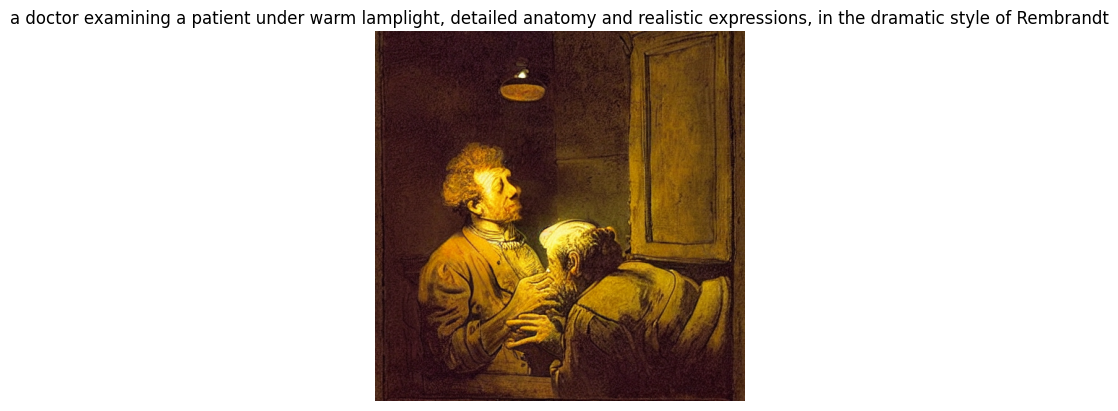

In [2]:
# sd_test.py
import os
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt

# 📁 모델 캐시 디렉토리 설정 (~/models에 저장)
model_path = os.path.expanduser("~/models/stable-diffusion-v1-4")

# ✅ 모델 로드
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    cache_dir=model_path
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# 🎯 테스트할 프롬프트 리스트
# prompts = [
#     "a cheerful group of people having lunch outdoors under trees, Renoir style, impressionist painting, warm colors",
#     "a young woman with a parasol walking through a blooming garden, soft brushstrokes, in the style of Pierre-Auguste Renoir",
#     "a couple dancing in a sunlit courtyard, impressionist lighting and color, Renoir oil painting style",
#     "children playing by the riverbank, soft pastels and blurred edges, Renoir-inspired impressionist art",
#     "a portrait of a smiling girl with curly hair, rosy cheeks and soft textures, painted in Renoir's style",
#     "a scene of a sunny French street café with people chatting, impressionist brushwork, warm afternoon light",
#     "a group of women in flowing dresses picking flowers in a meadow, vivid colors, Renoir impressionism",
#     "a relaxed picnic in the countryside with fruits, wine, and friends, dappled sunlight, Renoir style painting",
#     "a ballet dancer tying her shoes backstage, soft lighting, impressionist painting inspired by Renoir",
#     "a mother holding her child in a sun-filled room, warm and intimate mood, Renoir-inspired palette and softness"
# ]
prompts = [
    "a solemn man reading by candlelight, dramatic chiaroscuro lighting, Rembrandt style oil painting",
    "a woman in a golden dress sitting near a window, soft shadows and detailed textures, Baroque portrait in the style of Rembrandt",
    "an elderly scholar writing at his desk, surrounded by books and dim lamplight, moody and introspective, Rembrandt-inspired",
    "a young boy holding a birdcage, soft expression, deep shadows, and fine detail, painted in the style of Rembrandt",
    "a group of men gathered around a table, dramatic shadows, expressive faces, 17th century Dutch interior, Rembrandt style",
    "a contemplative woman praying in a candle-lit room, spiritual and intimate mood, chiaroscuro technique, Rembrandt portrait",
    "a self-portrait of an artist holding a brush, illuminated by warm directional light, heavy texture and realism, Rembrandt homage",
    "a nighttime scene of a man walking through a dark alley with a lantern, deep blacks and golden highlights, Rembrandt atmosphere",
    "a nobleman with a fur cloak and ornate collar, textured fabric and lifelike skin tones, classic Rembrandt portrait style",
    "a doctor examining a patient under warm lamplight, detailed anatomy and realistic expressions, in the dramatic style of Rembrandt"
]


# 🔄 각 프롬프트에 대해 이미지 생성
for i, prompt in enumerate(prompts):
    print(f"Generating image {i+1}/{len(prompts)}...")
    image = pipe(prompt).images[0]

    # 💾 이미지 저장
    # filename = f"output_{i+1:02d}.png"
    # image.save(filename)
    # print(f"Saved: {filename}")

    # 🖼️ 이미지 시각화
    plt.imshow(image)
    plt.axis("off")
    plt.title(prompt)
    plt.show()
